**Observer**

In [1]:
from enum import Enum


class InfectableType(Enum):
    SeasonalFlu = 1
    SARSCoV2 = 2
    Cholera = 3


class Observer:
    def __init__(self):
        
        self.observations = {
            InfectableType.SeasonalFlu: {
                'infections':        0,
                'hospitalizations' : 0,
                'deaths':            0,
                'recoveries':        0,
                'antibodies':        0
            },
            InfectableType.SARSCoV2: {
                'infections':        0,
                'hospitalizations' : 0,
                'deaths':            0,
                'recoveries':        0,
                'antibodies':        0
            },
            InfectableType.Cholera: {
                'infections':        0,
                'hospitalizations' : 0,
                'deaths':            0,
                'recoveries':        0,
                'antibodies':        0
            }
        }

    def notify(self, infectable_type, key):
        self.observations[infectable_type][key] += 1
        
    __instance = None
    def __new__(cls, *args):
        if cls.__instance is None:
            cls.__instance = object.__new__(cls)
        return cls.__instance

**Person**

<img src="images/Abstract Person Factory Class.svg"/>

In [2]:
from abc import ABC, abstractmethod
from random import randint

class PersonType(Enum):
    Default = 1
    Community = 2

class Person(ABC):
    MAX_TEMPERATURE_TO_SURVIVE = 44.0
    LOWEST_WATER_PCT_TO_SURVIVE = 0.4
    
    LIFE_THREATENING_TEMPERATURE = 40.0
    LIFE_THREATENING_WATER_PCT = 0.5
    
    def __init__(self, home_position=(0, 0), age=30, weight=70, health_dept=0):
        self.age = age
        self.weight = weight
        self.temperature = 36.6
        self.water = 0.6 * self.weight
        self.virus = None
        self.antibody_types = set()
        self.home_position = home_position
        self.position = home_position
        self.health_dept = health_dept
        self.state = Healthy(self)
    
    def day_actions(self):
        self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)

    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    def is_contacting(self, other):
        return self.position == other.position

    def fightvirus(self):
        if self.virus:
            self.virus.strength -= (3.0 / self.age)

    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)
    
    def set_state(self, state):
        self.state = state
    
    def is_life_threatening_condition(self):
        return self.temperature >= Person.LIFE_THREATENING_TEMPERATURE or \
           self.water / self.weight <= Person.LIFE_THREATENING_WATER_PCT
    
    def is_life_incompatible_condition(self):        
        return self.temperature >= Person.MAX_TEMPERATURE_TO_SURVIVE or \
            self.water / self.weight <= Person.LOWEST_WATER_PCT_TO_SURVIVE
    
    @abstractmethod
    def get_type(self):
        pass

class DefaultPerson(Person):
    def get_type(self):
        return PersonType.Default


class CommunityPerson(Person):
    def __init__(self, community_position=(0, 0), **kwargs):
        super().__init__(**kwargs)
        self.community_position = community_position
        
    def get_type(self):
        return PersonType.Community

In [3]:
from abc import ABC, abstractmethod

min_i, max_i = 0, 100
min_j, max_j = 0, 100
    
class State(ABC):
    def __init__(self, person): 
        self.person = person
        
    @abstractmethod
    def day_actions(self): pass

    @abstractmethod
    def night_actions(self): pass

    @abstractmethod
    def interact(self, other): pass

    @abstractmethod
    def get_infected(self, virus): pass


class Healthy(State):
    def day_actions(self):
        if self.person.get_type() == PersonType.Default:
            self.person.position = (randint(min_j, max_j), randint(min_i, max_i))
        else:
            self.person.position = self.person.community_position
            
    def night_actions(self):
        self.person.position = self.person.home_position

    def interact(self, other: Person): pass

    def get_infected(self, virus):
        if virus.get_type() not in self.person.antibody_types:
            self.person.virus = virus
            self.person.set_state(AsymptomaticSick(self.person))
            self.person.health_dept.observer.notify(virus.get_type(), 'infections')


class AsymptomaticSick(State):
    DAYS_SICK_TO_FEEL_BAD = 10
    
    def __init__(self, person):
        super().__init__(person)
        self.days_sick = 0

    def day_actions(self):
        self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position
        if self.days_sick == AsymptomaticSick.DAYS_SICK_TO_FEEL_BAD:
            self.person.set_state(SymptomaticSick(self.person))
        self.days_sick += 1

    def interact(self, other):
        other.get_infected(self.person.virus)

    def get_infected(self, virus): pass


class SymptomaticSick(State):
    def day_actions(self):
        self.person.progress_disease()
        
        if self.person.is_life_threatening_condition():
            self.person.health_dept.hospitalize(self.person)
            self.person.health_dept.observer.notify(self.person.virus.get_type(), 'hospitalizations')

        if self.person.is_life_incompatible_condition():
            self.person.set_state(Dead(self.person))
            self.person.health_dept.observer.notify(self.person.virus.get_type(), 'deaths')
            
    def night_actions(self):
        # try to fight the virus
        self.person.fightvirus()
        if self.person.virus.strength <= 0:
            self.person.set_state(Healthy(self.person))
            self.person.antibody_types.add(self.person.virus.get_type())
            self.person.health_dept.observer.notify(self.person.virus.get_type(), 'recoveries')
            self.person.health_dept.observer.notify(self.person.virus.get_type(), 'antibodies')
            self.person.virus = None
            
    def interact(self, other): 
        other.get_infected(self.person.virus)

    def get_infected(self, virus): pass

    
class Dead(State):
    def day_actions(self): pass

    def night_actions(self): pass

    def interact(self, other): pass

    def get_infected(self, virus): pass

In [4]:
class AbstractPersonFactory(ABC):
    def __init__(self, health_dept, min_j, max_j, min_i, max_i):
        self.health_dept = health_dept
        self.min_age, self.max_age = 1, 90
        self.min_weight, self.max_weight = 30, 120
        self.min_j, self.max_j, self.min_i, self.max_i = min_j, max_j, min_i, max_i

    @abstractmethod
    def get_person(self) -> Person:
        pass

    
class DefaultPersonFactory(AbstractPersonFactory):
    def get_person(self) -> Person:
        return DefaultPerson(
            home_position=(randint(self.min_j, self.max_j), randint(self.min_i, self.max_i)),
            age=randint(self.min_age, self.max_age),
            weight=randint(self.min_weight, self.max_weight),
            health_dept=self.health_dept
        )


class CommunityPersonFactory(AbstractPersonFactory):
    def __init__(self, *args, community_position=(0, 0)):
        super().__init__(*args)
        self.community_position = community_position

    def get_person(self) -> Person:
        return CommunityPerson(
            home_position=(randint(self.min_j, self.max_j), randint(self.min_i, self.max_i)),
            age=randint(self.min_age, self.max_age),
            weight=randint(self.min_weight, self.max_weight),
            community_position=self.community_position,
            health_dept=self.health_dept
        )

**Infectable**

<img src="images/Factory Method Infectable Class.svg">

In [5]:
from random import expovariate

class Infectable(ABC):
    def __init__(self, strength=1.0, contag=1.0):
        # contag is for contagiousness so we have less typos
        self.strength = strength
        self.contag = contag

    @abstractmethod
    def cause_symptoms(self, person: Person):
        pass
    
    @abstractmethod
    def get_type(self):
        pass


class SeasonalFluVirus(Infectable):
    def cause_symptoms(self, person: Person):
        person.temperature = 38.0
        
    def get_type(self):
        return InfectableType.SeasonalFlu
    
    
class SARSCoV2(Infectable):
    def cause_symptoms(self, person: Person):
        person.temperature += expovariate(0.4)
        
    def get_type(self):
        return InfectableType.SARSCoV2
    
    
class Cholera(Infectable):
    def cause_symptoms(self, person: Person):
        person.water -= expovariate(25.0) * person.weight
    
    def get_type(self):
        return InfectableType.Cholera
    
    
def get_infectable(infectable_type: InfectableType):
    if InfectableType.SeasonalFlu == infectable_type:
        return SeasonalFluVirus(strength=expovariate(10.0), contag=expovariate(10.0))
    
    elif InfectableType.SARSCoV2 == infectable_type:
        return SARSCoV2(strength=expovariate(2.0), contag=expovariate(2.0))
    
    elif InfectableType.Cholera == infectable_type:
        return Cholera(strength=expovariate(2.0), contag=expovariate(2.0))
    
    else:
        raise ValueError()

**Drug**

<img src="images/Drug Class.svg"/>

In [6]:
class Drug(ABC):
    def apply(self, person):
        # somehow reduce person's symptoms
        pass


class AntipyreticDrug(Drug): pass


class Aspirin(AntipyreticDrug):
    '''A cheaper version of the fever/pain killer.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.5
        
    def apply(self, person):
        person.temperature = max(36.6, person.temperature - self.dose * self.efficiency)


class Ibuprofen(AntipyreticDrug):
    '''A more efficient version of the fever/pain killer.'''
    def __init__(self, dose):
        self.dose = dose
        
    def apply(self, person):
        person.temperature = 36.6


class RehydrationDrug(Drug): pass

class Glucose(RehydrationDrug):
    '''A cheaper version of the rehydration drug.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        person.water = min(person.water + self.dose * self.efficiency,
                            0.6 * person.weight)


class Rehydron(RehydrationDrug):
    '''A more efficient version of the rehydration drug.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 1.0
        
    def apply(self, person):
        person._water = 0.6 * person.weight


class AntivirusDrug(Drug): pass

class Placebo(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose

    def apply(self, person): pass


class AntivirusSeasonalFlu(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 1.0
        
    def apply(self, person):
        if isinstance(person.virus, SeasonalFluVirus):
            person.virus.strength -= self.dose * self.efficiency
            
        elif isinstance(person.virus, SARSCoV2):
            person.virus.strength -= self.dose * self.efficiency / 10.0


class AntivirusSARSCoV2(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        if isinstance(person.virus, SARSCoV2):
            person.virus.strength -= self.dose * self.efficiency


class AntivirusCholera(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        if isinstance(person.virus, Cholera):
            person.virus.strength -= self.dose * self.efficiency

**DrugReposistory**

<img src="images/DrugRepository Class.svg"/>

In [7]:
from typing import List


class DrugRepository(ABC):
    def __init__(self):
        self.treatment = []
        
    @abstractmethod
    def get_antifever(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_rehydration(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_seasonal_antivirus(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_sars_antivirus(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_cholera_antivirus(self, dose) -> Drug: pass
    
    def get_treatment(self):
        return self.treatment


class CheapDrugRepository(DrugRepository):
    def get_antifever(self, dose) -> Drug:
        return Aspirin(dose)

    def get_rehydration(self, dose) -> Drug:
        return Glucose(dose)

    def get_seasonal_antivirus(self, dose) -> Drug:
        return Placebo(dose)

    def get_sars_antivirus(self, dose) -> Drug:
        return Placebo(dose)

    def get_cholera_antivirus(self, dose) -> Drug:
        return Placebo(dose)


class ExpensiveDrugRepository(DrugRepository):
    def get_antifever(self, dose) -> Drug:
        return Ibuprofen(dose)

    def get_rehydration(self, dose) -> Drug:
        return Rehydron(dose)

    def get_seasonal_antivirus(self, dose) -> Drug:
        return AntivirusSeasonalFlu(dose)

    def get_sars_antivirus(self, dose) -> Drug:
        return AntivirusSARSCoV2(dose)

    def get_cholera_antivirus(self, dose) -> Drug:
        return AntivirusCholera(dose)

In [8]:
class DrugRepositoryType(Enum):
    Cheap = 1
    Expensive = 2
    
def get_drug_repository(drug_repository_type: DrugRepositoryType):
    if DrugRepositoryType.Cheap == drug_repository_type:
        return CheapDrugRepository()
    
    elif DrugRepositoryType.Expensive == drug_repository_type:
        return ExpensiveDrugRepository()
    
    else:
        raise ValueError()

**Prescriptor**

<img src="images/AbstractPrescriptor Class.svg"/>

In [9]:
class AbstractPrescriptor(ABC):
    def __init__(self, drug_repository):
        self.drug_repository = drug_repository
        
    @abstractmethod
    def create_prescription(self) -> List[Drug]:
        pass
    

class SeasonalFluPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, antifever_dose=1, antivirus_dose=1):
        super().__init__(drug_repository)
        self.antifever_dose = antifever_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_antifever(self.antifever_dose),
            self.drug_repository.get_seasonal_antivirus(self.antivirus_dose)
        ]

    
class CovidPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, antifever_dose=1, antivirus_dose=1):
        super().__init__(drug_repository)
        self.antifever_dose = antifever_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_antifever(self.antifever_dose),
            self.drug_repository.get_sars_antivirus(self.antivirus_dose)
        ]


class CholeraPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, rehydradation_dose=1, antivirus_dose=1):
        super().__init__(drug_repository)
        self.rehydradation_dose = rehydradation_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_rehydration(self.rehydradation_dose),
            self.drug_repository.get_cholera_antivirus(self.antivirus_dose)
        ]


def get_prescription_method(disease_type, drug_repository):
    if InfectableType.SeasonalFlu == disease_type:
        return SeasonalFluPrescriptor(drug_repository, uniform(0,0.2), uniform(0,0.2))

    elif InfectableType.SARSCoV2 == disease_type:
        return CovidPrescriptor(drug_repository, uniform(0,0.2), uniform(0,0.2))

    elif InfectableType.Cholera == disease_type:
        return CholeraPrescriptor(drug_repository, uniform(0,0.2), uniform(0,0.2))

    else:
        raise ValueError()

**Hospital**

In [10]:
from random import uniform

class Hospital:
    def __init__(self, capacity):
        self.capacity = capacity
        self.patients = []
        self.tests = []
        if randint(0,1) == 0:
            self.drug_repository = get_drug_repository(DrugRepositoryType.Cheap)
        else:
            self.drug_repository = get_drug_repository(DrugRepositoryType.Expensive)

    def _treat_patient(self, patient):
        if patient.virus is None:
            self.patients.remove(patient)
        else:
            disease_type = patient.virus.get_type()
            prescription_method = get_prescription_method(disease_type, self.drug_repository)
            prescription_drugs = prescription_method.create_prescription()
            for drug in prescription_drugs:
                drug.apply(patient)

    def treat_patients(self):
        for patient in self.patients:
            self._treat_patient(patient)

**Department Of Health**

In [11]:
from copy import deepcopy
import matplotlib.pyplot as plt


class DepartmentOfHealth:
    def __init__(self, hospitals, observer):
        self.hospitals = hospitals
        self.observer = observer
        self.trace = []
    
    def update_trace(self):
        loc = deepcopy(self.observer.observations)
        self.trace.append(loc)
    
    def monitor_situation(self):
        infectable_list = list(self.trace[0].keys())
        fields_list = ('infections', 'hospitalizations', 'deaths', 'recoveries')
        color_dict = {
            'infections':       'black',
            'hospitalizations': 'blue',
            'deaths':           'red',
            'recoveries':       'green'
        }
        for inf_name in infectable_list:
            plt.figure(figsize=(12,6))
            for field in fields_list:
                trace = [rec[inf_name][field] for rec in self.trace]
                plt.plot(trace, color=color_dict[field], label=field)
            plt.title(inf_name)
            plt.legend()
            plt.show()
    
    def hospitalize(self, person):
        for hospital in self.hospitals:
            if len(hospital.patients) < hospital.capacity:
                hospital.patients.append(person)
                break
    
    def make_policy(self):
        pass
    
    __instance = None
    def __new__(cls, *args):
        if cls.__instance is None:
            cls.__instance = object.__new__(cls)
        return cls.__instance

**GlobalContext**

In [12]:
class GlobalContext:
    def __init__(self, canvas, persons, health_dept):
        self.canvas = canvas
        self.persons = persons
        self.health_dept = health_dept
        
    __instance = None
    def __new__(cls, *args):
        if cls.__instance is None:
            cls.__instance = object.__new__(cls)
        return cls.__instance

**Simulation**

In [13]:
def simulate_day(context):
    persons, health_dept, hospitals = context.persons, context.health_dept, context.health_dept.hospitals

    health_dept.make_policy()
    
    for hospital in hospitals:
        hospital.treat_patients()
    
    for person in persons:
        person.day_actions()
    
    for person in persons:
        for other in persons:
            if person is not other and person.is_contacting(other):
                person.interact(other)
                
    for person in persons:
        person.night_actions()
        
    health_dept.update_trace()

In [14]:
from random import randint

def create_observer():
    return Observer()

def create_persons(health_dept, min_j, max_j, min_i, max_i, n_persons):
    factory_params = (health_dept, min_j, max_j, min_i, max_i)
    
    default_factory = DefaultPersonFactory(*factory_params)
    community_factory = CommunityPersonFactory(*factory_params, community_position=(50, 50))

    n_default_persons = int(n_persons * 0.75)
    n_community_persons = n_persons - n_default_persons

    persons = []
    for i in range(n_default_persons):
        persons.append(default_factory.get_person())
        
    for i in range(n_community_persons):
        persons.append(community_factory.get_person())

    return persons

def create_hospitals(n_hospitals):
    hospitals = [
        Hospital(capacity=50)
        for i in range(n_hospitals)
    ]
    return hospitals

def create_department_of_health(hospitals, observer):
    return DepartmentOfHealth(hospitals, observer)

def initialize():
    # our little country
    min_i, max_i = 0, 50
    min_j, max_j = 0, 50
    
    #our observer
    observer = create_observer()
    
    # our healthcare system
    n_hospitals = 2
    hospitals = create_hospitals(n_hospitals)
    
    health_dept = create_department_of_health(hospitals, observer)
    
    # our citizens
    n_persons = 1000
    persons = create_persons(health_dept, min_j, max_j, min_i, max_i, n_persons)
    
    # infected citizens
    persons_infected_season_flu = persons[0:10]
    persons_infected_sarscov2 = persons[10:20]
    persons_infected_cholera = persons[20:30]
    
    for person in persons_infected_season_flu:
        person.virus = get_infectable(InfectableType.SeasonalFlu)
        person.state = AsymptomaticSick(person)
        person.health_dept.observer.notify(InfectableType.SeasonalFlu, 'infections')
    for person in persons_infected_sarscov2:
        person.virus = get_infectable(InfectableType.SARSCoV2)
        person.state = AsymptomaticSick(person)
        person.health_dept.observer.notify(InfectableType.SARSCoV2, 'infections')
    for person in persons_infected_cholera:
        person.virus = get_infectable(InfectableType.Cholera)
        person.state = AsymptomaticSick(person)
        person.health_dept.observer.notify(InfectableType.Cholera, 'infections')
    
    # global context
    context = GlobalContext(
        (min_j, max_j, min_i, max_i),
        persons,
        health_dept
    )

    return context

In [15]:
import tqdm.notebook as tqdm

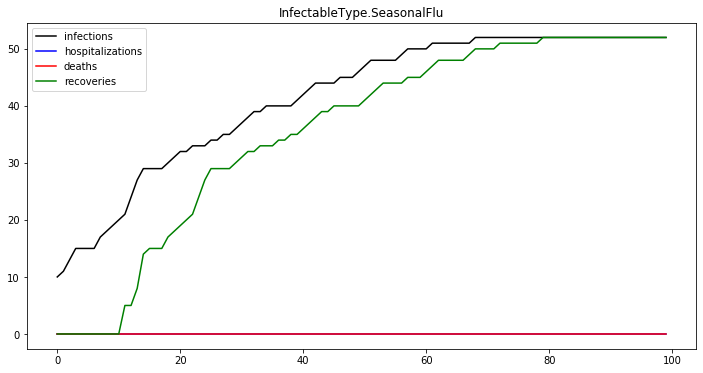

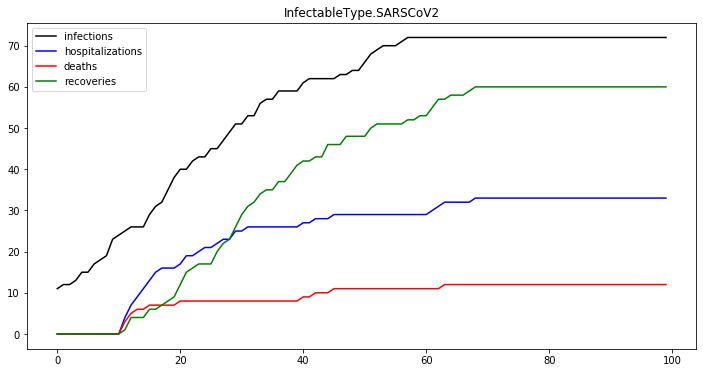

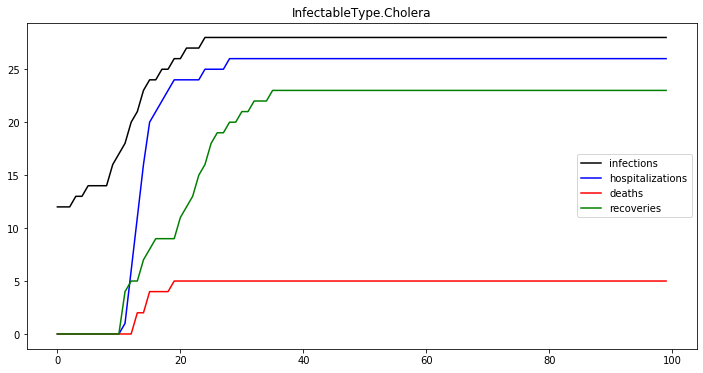

In [16]:
context = initialize()

for day in tqdm.tqdm(range(100)):
    simulate_day(context)

context.health_dept.monitor_situation()

Number of people with antibodies == Number of recoveries 